# VGG16-BN Transfer Learning: Baseline, Fine‑Tuning

This notebook reproduces the VGG16 transfer‑learning pipeline on Flowers102 and evaluates freezing strategies. The goal is to show how transfer learning, and layer freezing affect validation and test accuracy.

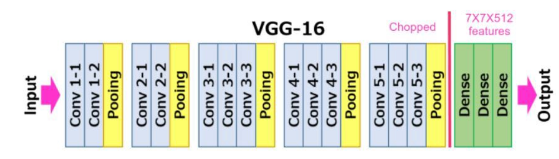

The Visual Geometry Group (VGG) family is a set of convolutional networks that stacks many small 3x3 filters to build deep networks with a simple and uniform design. We selected VGG16 as it is a strong transfer-learning baseline. It has an input layer, followed by 5 convolutional blocks containing stacked 3x3 convolutional layers with increasing number of filters and a max-pooling layer, followed by 3 FC layers. In the VGG16 Batch Normalisation (VGG16-BN) variant, batch normalisation layers are inserted after each convolutional layer to improve stability.

Building on the VGG16-BN transfer learning baseline, this section evaluates the effect of freezing layers and changing classifier heads on model performance. Freezing layers help to reduce computational cost and prevent overfitting. The original FC classifier head allows learning of complex relationships but might cause overfitting and high computational cost. The GAP classifier head can significantly reduce model size and improves generalisation but might not capture intricate patterns.


## Imports and Reproducibility Setup

In [1]:
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from tqdm import tqdm
import torchvision.models as models
import torchvision.transforms as transforms
from torchvision import datasets, models
from torchvision.datasets import Flowers102
from torchvision.models import resnet18, ResNet18_Weights
from torchvision.transforms import v2
from torchvision.models import efficientnet_b0, EfficientNet_B0_Weights
from torchvision.models import vgg16_bn, VGG16_BN_Weights
from torch.utils.data import DataLoader, default_collate

import matplotlib.pyplot as plt
import random
import numpy as np
from itertools import product
import copy, time

from torch.utils.data import Dataset
from sklearn.neighbors import KNeighborsClassifier
from sklearn.manifold import TSNE

NUM_CLASSES = 102

seed = 1001
random.seed(seed)
torch.manual_seed(seed)
np.random.seed(seed)
torch.cuda.manual_seed_all(seed)
torch.backends.cudnn.deterministic = True
rng = np.random.default_rng(seed)

## Data Preparation and Helper Functions

In [2]:
# resize images to 224x224 in line with ResNet/EfficientNet input size, normalize images
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225]),
])


In [3]:
# load the dataset
train_dataset = datasets.Flowers102(root='./data', split='train', download=True, transform=transform)
val_dataset   = datasets.Flowers102(root='./data', split='val',   download=True, transform=transform)
test_dataset  = datasets.Flowers102(root='./data', split='test',  download=True, transform=transform)


In [4]:
# create data loaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True,  num_workers=4)
val_loader   = DataLoader(val_dataset,   batch_size=32, shuffle=False, num_workers=4)
test_loader  = DataLoader(test_dataset,  batch_size=32, shuffle=False, num_workers=4)


In [5]:
class EarlyStopper:
    def __init__(self, patience=5, min_delta=0.0, verbose=True, model_path='model.pth'):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.min_validation_loss = np.inf
        self.verbose = verbose
        self.model_path = model_path

    def early_stop(self, validation_loss, model):
        if validation_loss < self.min_validation_loss - self.min_delta:
            self.min_validation_loss = validation_loss
            self.counter = 0
            if self.model_path is not None:
                torch.save(model.state_dict(), self.model_path)
            return False
        else:
            self.counter += 1
            if self.counter >= self.patience:
                if self.verbose:
                    print("Early stopping triggered.")
                return True
        return False

In [6]:
# Model builders

def build_vgg16bn_fc_head(num_classes=NUM_CLASSES):
    """
    VGG16-BN with standard FC classifier head:
    [4096 -> 4096 -> num_classes]
    """
    weights = VGG16_BN_Weights.IMAGENET1K_V1
    base = vgg16_bn(weights=weights)

    # Replace final layer to match Flowers102
    in_features = base.classifier[-1].in_features
    base.classifier[-1] = nn.Linear(in_features, num_classes)

    return base


class VGG16BN_GAP(nn.Module):
    """
    VGG16-BN with Global Average Pooling head:
      features -> GAP -> Dropout -> Linear(512 -> num_classes)
    """
    def __init__(self, num_classes=NUM_CLASSES):
        super().__init__()
        weights = VGG16_BN_Weights.IMAGENET1K_V1
        base = vgg16_bn(weights=weights)

        self.features = base.features  # conv backbone

        # GAP head (512 channels after last conv)
        self.gap_head = nn.Sequential(
            nn.AdaptiveAvgPool2d((1, 1)),
            nn.Flatten(),
            nn.Dropout(p=0.5),
            nn.Linear(512, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = self.gap_head(x)
        return x


In [7]:
# Fine-tuning strategies

def set_trainable_params_vgg16bn_fc(model, mode):
    """
    mode: 'frozen', 'partial', 'full'
    - FC head variant: uses model.classifier as head.
    """
    assert mode in ["frozen", "partial", "full"]

    # start: freeze everything
    for p in model.parameters():
        p.requires_grad = False

    if mode == "frozen":
        # Only classifier trainable
        for p in model.classifier.parameters():
            p.requires_grad = True

    elif mode == "partial":
        # Unfreeze classifier + last conv block
        for p in model.classifier.parameters():
            p.requires_grad = True

        # Last conv block of VGG16-BN:
        # features[-6:] roughly corresponds to last block (3x conv + 3x bn)
        for layer in list(model.features.children())[-6:]:
            for p in layer.parameters():
                p.requires_grad = True

    elif mode == "full":
        # Everything trainable
        for p in model.parameters():
            p.requires_grad = True

    return model


def set_trainable_params_vgg16bn_gap(model, mode):
    """
    mode: 'frozen', 'partial', 'full'
    - GAP head variant: uses model.features + model.gap_head.
    """
    assert mode in ["frozen", "partial", "full"]

    for p in model.parameters():
        p.requires_grad = False

    if mode == "frozen":
        for p in model.gap_head.parameters():
            p.requires_grad = True

    elif mode == "partial":
        for p in model.gap_head.parameters():
            p.requires_grad = True

        # Unfreeze last conv block in features
        for layer in list(model.features.children())[-6:]:
            for p in layer.parameters():
                p.requires_grad = True

    elif mode == "full":
        for p in model.parameters():
            p.requires_grad = True

    return model



In [8]:
# Optimizer helper (head vs backbone LRs)

def make_optimizer(model, head_modules, lr_head=1e-4, lr_backbone=1e-5, weight_decay=1e-4):
    """
    Create Adam optimizer with separate LR for head vs backbone parameters.
    head_modules: list of nn.Modules considered "head".
    """
    head_param_ids = set()
    for m in head_modules:
        for p in m.parameters():
            head_param_ids.add(id(p))

    head_params = []
    backbone_params = []

    for p in model.parameters():
        if not p.requires_grad:
            continue
        if id(p) in head_param_ids:
            head_params.append(p)
        else:
            backbone_params.append(p)

    param_groups = []
    if backbone_params:
        param_groups.append({"params": backbone_params, "lr": lr_backbone, "weight_decay": weight_decay})
    if head_params:
        param_groups.append({"params": head_params, "lr": lr_head, "weight_decay": weight_decay})

    # If only head is trainable, this still works.
    return optim.Adam(param_groups)


In [9]:
# Training / Eval loops

def train_model(
    model,
    train_loader,
    val_loader,
    optimizer,
    num_epochs=40,
    patience=5,
    model_path="vgg_variant.pth",
    print_prefix=""
):
    criterion = nn.CrossEntropyLoss()
    stopper = EarlyStopper(patience=patience, min_delta=0.0,
                           verbose=True, model_path=model_path)

    train_losses, val_losses = [], []
    train_accs, val_accs = [], []

    best_val_acc = 0.0

    for epoch in range(1, num_epochs + 1):
        # ---- Train ----
        model.train()
        running_loss = 0.0
        running_correct = 0
        total = 0

        for X, y in train_loader:

            optimizer.zero_grad()
            logits = model(X)
            loss = criterion(logits, y)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * X.size(0)
            preds = logits.argmax(dim=1)
            running_correct += (preds == y).sum().item()
            total += X.size(0)

        train_loss = running_loss / total
        train_acc = running_correct / total
        train_losses.append(train_loss)
        train_accs.append(train_acc)

        # ---- Val ----
        model.eval()
        val_running_loss = 0.0
        val_running_correct = 0
        val_total = 0

        with torch.no_grad():
            for Xv, yv in val_loader:
                logits_v = model(Xv)
                loss_v = criterion(logits_v, yv)

                val_running_loss += loss_v.item() * Xv.size(0)
                preds_v = logits_v.argmax(dim=1)
                val_running_correct += (preds_v == yv).sum().item()
                val_total += Xv.size(0)

        val_loss = val_running_loss / val_total
        val_acc = val_running_correct / val_total
        val_losses.append(val_loss)
        val_accs.append(val_acc)

        if print_prefix:
            print_prefix_str = f"[{print_prefix}] "
        else:
            print_prefix_str = ""

        print(f"{print_prefix_str}Epoch {epoch:02d} | "
              f"Train Loss: {train_loss:.4f}/ Train Acc: {train_acc:.4f} | "
              f"Val Loss: {val_loss:.4f}/ Val Acc: {val_acc:.4f}")

        # Track best val acc separately
        best_val_acc = max(best_val_acc, val_acc)

        # Early stopping on val loss
        if stopper.early_stop(val_loss, model):
            break

    # Load best weights (saved inside EarlyStopper)
    if model_path is not None:
        model.load_state_dict(torch.load(model_path))

    return {
        "model": model,
        "train_loss": train_losses,
        "val_loss": val_losses,
        "train_acc": train_accs,
        "val_acc": val_accs,
        "best_val_acc": best_val_acc,
        "model_path": model_path,
    }


def evaluate_model(model, loader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for X, y in loader:
            logits = model(X)
            preds = logits.argmax(dim=1)
            correct += (preds == y).sum().item()
            total += X.size(0)
    return correct / total



## Training Loop
Here are the variants tested:
| Modification      | Variant       | 
|-----------------|-----------------|
| Classifier Head   | FC head, GAP head   | 
| Fine-tuning Strategy | Full, Partial, Frozen | 

In [10]:
# Run all 6 variants

experiments = [
    ("FC",  "frozen"),
    ("FC",  "partial"),
    ("FC",  "full"),
    ("GAP", "frozen"),
    ("GAP", "partial"),
    ("GAP", "full"),
]

histories = {}
summary = {}

for head_type, mode in experiments:
    print("\n" + "=" * 70)
    print(f"Training VGG16-BN | Head: {head_type} | Finetune: {mode}")
    print("=" * 70)

    if head_type == "FC":
        model = build_vgg16bn_fc_head(NUM_CLASSES)
        model = set_trainable_params_vgg16bn_fc(model, mode)
        head_modules = [model.classifier]
        tag = f"vgg16bn_fc_{mode}"
    else:
        model = VGG16BN_GAP(NUM_CLASSES)
        model = set_trainable_params_vgg16bn_gap(model, mode)
        head_modules = [model.gap_head]
        tag = f"vgg16bn_gap_{mode}"

    optimizer = make_optimizer(
        model,
        head_modules=head_modules,
        lr_head=1e-4,
        lr_backbone=1e-5 if mode != "frozen" else 1e-4,
        weight_decay=1e-4,
    )

    model_path = f"{tag}.pth"

    hist = train_model(
        model=model,
        train_loader=train_loader,
        val_loader=val_loader,
        optimizer=optimizer,
        num_epochs=40,
        patience=5,
        model_path=model_path,
        print_prefix=tag
    )

    # Evaluate best checkpoint on test set
    best_model = hist["model"]
    test_acc = evaluate_model(best_model, test_loader)

    hist["test_acc"] = test_acc
    histories[tag] = hist

    summary[tag] = {
        "best_val_acc": hist["best_val_acc"],
        "test_acc": test_acc,
    }

    print(f"=> {tag} | Best Val Acc: {hist['best_val_acc']:.4f} | Test Acc: {test_acc:.4f}")



Training VGG16-BN | Head: FC | Finetune: frozen
[vgg16bn_fc_frozen] Epoch 01 | Train Loss: 4.4494/ Train Acc: 0.0755 | Val Loss: 3.7947/ Val Acc: 0.3775
[vgg16bn_fc_frozen] Epoch 02 | Train Loss: 2.5909/ Train Acc: 0.5088 | Val Loss: 1.9489/ Val Acc: 0.5971
[vgg16bn_fc_frozen] Epoch 03 | Train Loss: 0.9698/ Train Acc: 0.7922 | Val Loss: 1.2135/ Val Acc: 0.7284
[vgg16bn_fc_frozen] Epoch 04 | Train Loss: 0.3190/ Train Acc: 0.9539 | Val Loss: 0.9636/ Val Acc: 0.7716
[vgg16bn_fc_frozen] Epoch 05 | Train Loss: 0.1222/ Train Acc: 0.9912 | Val Loss: 0.8278/ Val Acc: 0.7961
[vgg16bn_fc_frozen] Epoch 06 | Train Loss: 0.0644/ Train Acc: 0.9971 | Val Loss: 0.7579/ Val Acc: 0.8127
[vgg16bn_fc_frozen] Epoch 07 | Train Loss: 0.0362/ Train Acc: 1.0000 | Val Loss: 0.7702/ Val Acc: 0.7843
[vgg16bn_fc_frozen] Epoch 08 | Train Loss: 0.0321/ Train Acc: 0.9971 | Val Loss: 0.7420/ Val Acc: 0.8059
[vgg16bn_fc_frozen] Epoch 09 | Train Loss: 0.0216/ Train Acc: 0.9990 | Val Loss: 0.7222/ Val Acc: 0.8167
[vgg16

## Data Visualisation and Plots

In [11]:
# Plot utilities

# Loss and Accuracy Plots for each variant
def plot_history(tag):
    """Plot loss & accuracy for a single experiment tag."""
    h = histories[tag]
    epochs = range(1, len(h["train_loss"]) + 1)

    plt.figure(figsize=(10, 5))

    plt.subplot(1, 2, 1)
    plt.plot(epochs, h["train_loss"], label="Train")
    plt.plot(epochs, h["val_loss"], label="Val")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title(f"{tag}: Loss")
    plt.grid(True)
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs, h["train_acc"], label="Train")
    plt.plot(epochs, h["val_acc"], label="Val")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.title(f"{tag}: Accuracy")
    plt.grid(True)
    plt.legend()

    plt.tight_layout()
    plt.show()

# Bar: Best validation and test accuracy per variant
def plot_summary_bar(summary_dict):
    """Bar chart comparing best val & test acc across all configs."""
    labels = list(summary_dict.keys())
    val_scores = [summary_dict[k]["best_val_acc"] for k in labels]
    test_scores = [summary_dict[k]["test_acc"] for k in labels]

    x = np.arange(len(labels))
    width = 0.35

    plt.figure(figsize=(14, 5))
    plt.bar(x - width/2, val_scores, width, label='Best Val Acc')
    plt.bar(x + width/2, test_scores, width, label='Test Acc')

    plt.xticks(x, labels, rotation=45, ha="right")
    plt.ylim(0.0, 1.0)
    plt.ylabel("Accuracy")
    plt.title("VGG16-BN: FC vs GAP | Frozen vs Partial vs Full FT")
    plt.legend()
    plt.grid(axis="y", linestyle="--", alpha=0.4)
    plt.tight_layout()
    plt.show()


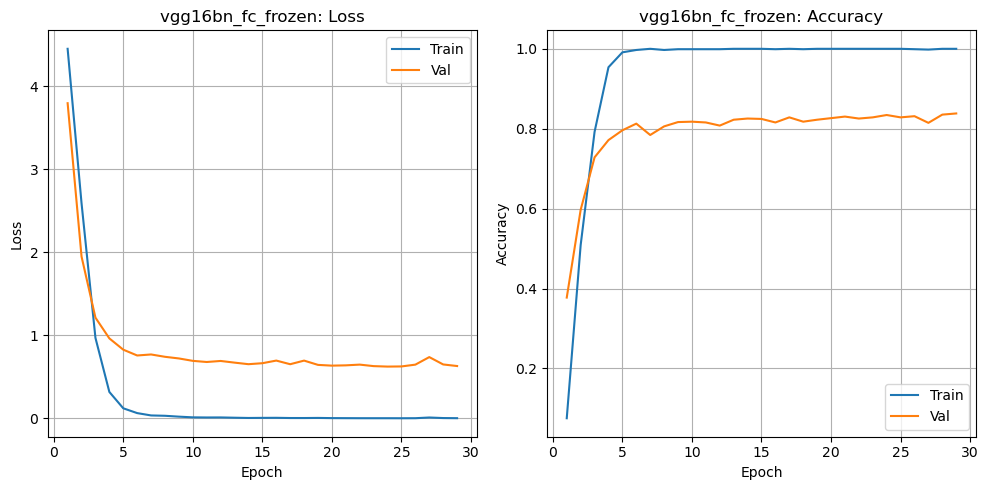

In [12]:
plot_history("vgg16bn_fc_frozen")

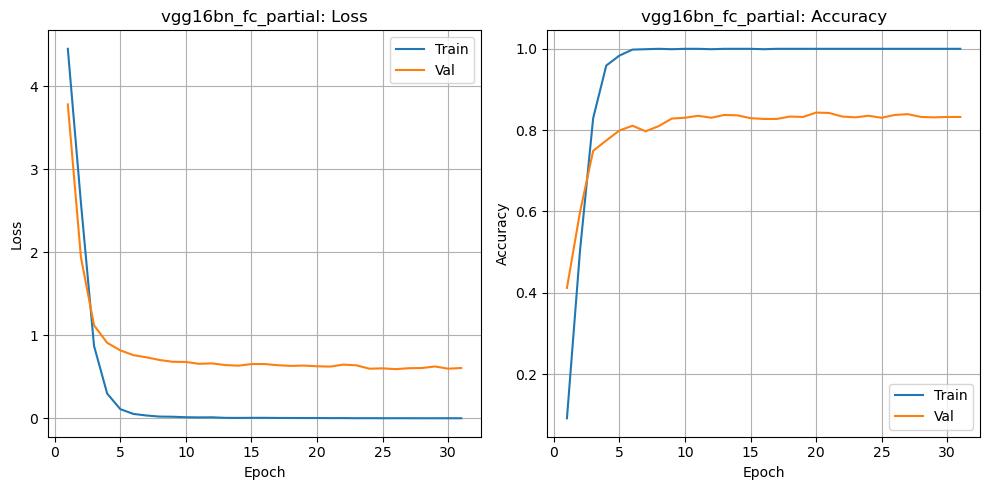

In [31]:
plot_history("vgg16bn_fc_partial")

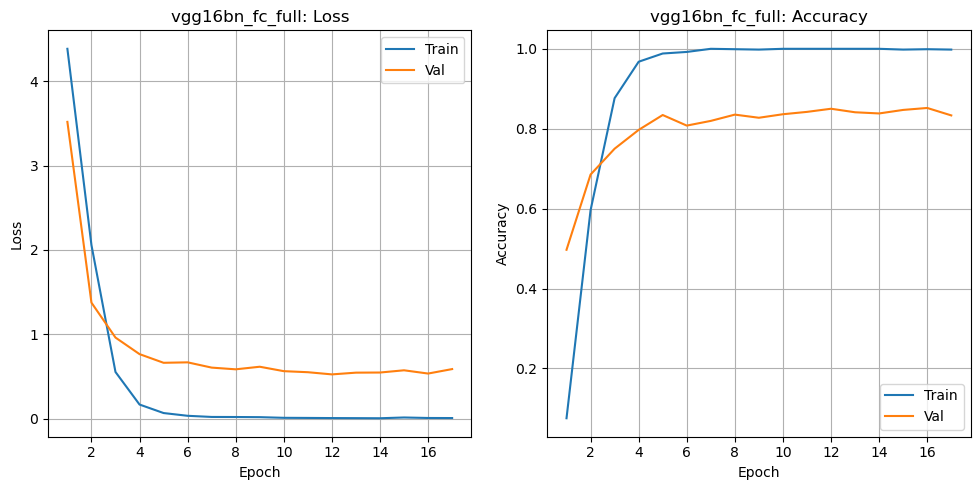

In [33]:
plot_history("vgg16bn_fc_full")

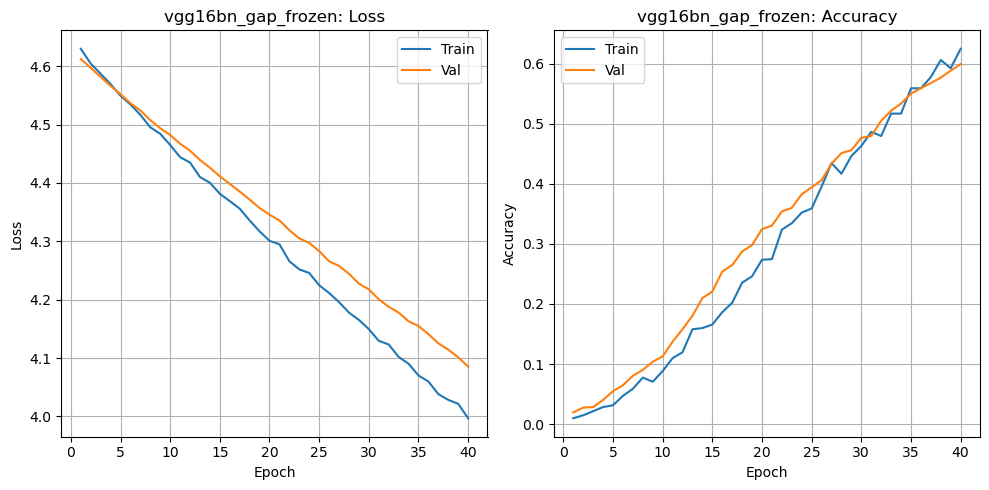

In [35]:
plot_history("vgg16bn_gap_frozen")

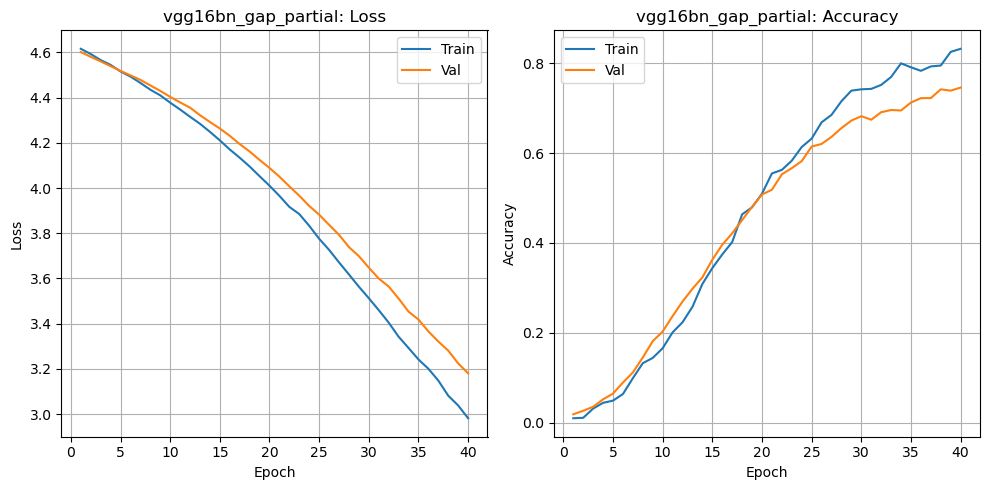

In [29]:
plot_history("vgg16bn_gap_partial")

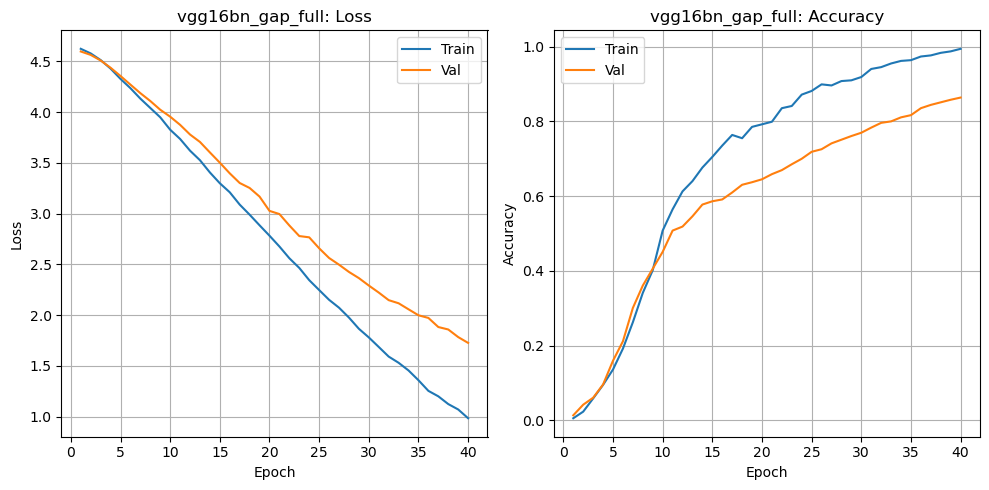

In [13]:
plot_history("vgg16bn_gap_full")

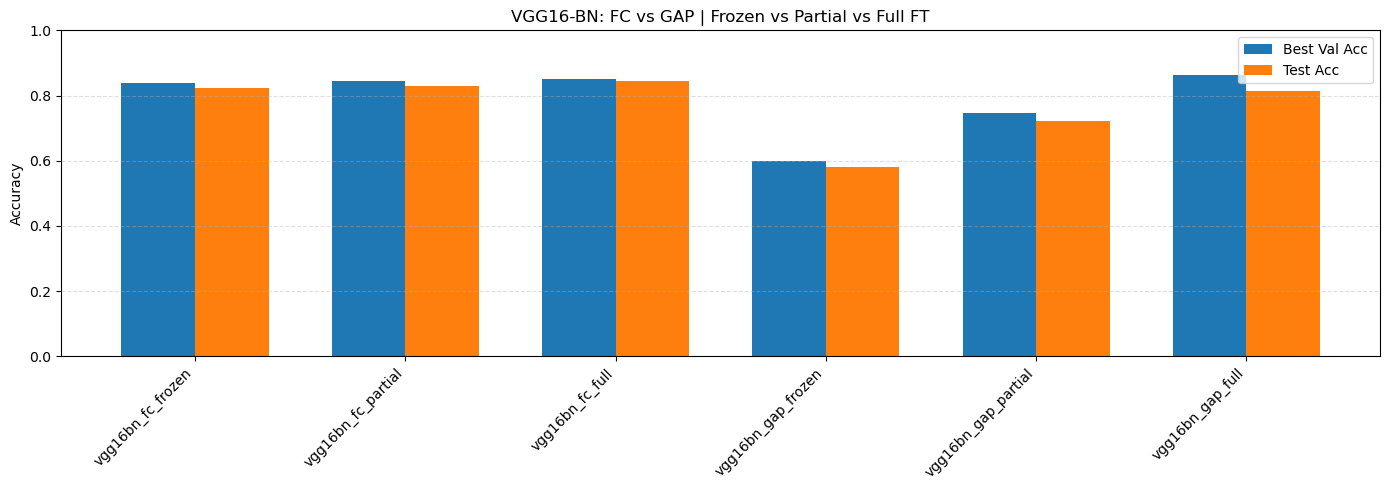

In [14]:
plot_summary_bar(summary)